# XRP Log Return vs Raw Range Analysis

This notebook investigates two complementary measures of short-term price behavior for XRP:

- **Log Return**: log(Close_t / Close_{t-1}), which reflects **net directional movement** from one candle to the next
- **Raw Range**: High_t - Low_t, which captures **intraperiod volatility**, regardless of direction

As requested in advisor feedback, we explore how these metrics behave:
- Around a **large volatility spike** (February 3, 2025)
- During a **recent week of data** (July 10-18, 2025)
- Across the **entire 2025 dataset**, using hourly resampling

We visualize both time series and histograms to understand how return and range reveal different aspects of volatility:
- **Log returns** highlight displacement between closes
- **Raw range** reveals turbulence within a candle

The dataset consists of 1-minute XRP/USDT candles pulled from Binance, saved in `xrpdata_2025.csv` and updated through July 18, 2025.

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the XRP dataset and parse timestamp columns as datetime
df = pd.read_csv("xrpdata_2025.csv", parse_dates=["Open time", "Close time"])

# Sort data chronologically just in case it's out of order
df = df.sort_values("Open time")

# Set "Open time" as the index for time series operations
df = df.set_index("Open time")

# Compute 1-minute log returns (close-to-close)
# R_t = log(Close_t / Close_{t-1})
df["log_return"] = np.log(df["Close"] / df["Close"].shift(1))

# Compute raw intraperiod range: High - Low
df["raw_range"] = df["High"] - df["Low"]

# Show the first and last rows to verify the time span and column structure
display(df.head(1))
display(df.tail(1))

,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,log_return,raw_range
Open time,,,,,,,,,,,,,
2025-01-01,2.0836,2.0848,2.0811,2.0848,101250.0,2025-01-01 00:00:59.999,210867.0156,636.0,26843.0,55906.8716,0.0,NaN,0.0037


,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,log_return,raw_range
Open time,,,,,,,,,,,,,
2025-07-18 23:58:00,3.4174,3.4177,3.4146,3.4153,109806.7,2025-07-18 23:58:59.999,375046.3376,1034.0,91019.7,310877.51649,0.0,-0.000644,0.0031


## Detection of Maximum Instantaneous Log Return

To identify the most volatile moment in the price series, we locate the timestamp corresponding to the **maximum absolute 1-minute log return**. This is computed as:

log_return_t = log(Close_t / Close_{t-1})

Taking the absolute value allows us to capture the most extreme displacement between consecutive closes, regardless of direction (positive or negative).

Once the timestamp of the largest |log return| is found, we extract a **6-hour symmetric window** around that moment:

- 3 hours **before** the jump
- 3 hours **after** the jump
- Resulting in a time slice of 361 rows (1-minute frequency)

This localized window is used for focused visualization and comparison of:

- Net directional change (log return)
- Intraperiod volatility (raw price range: High - Low)

The purpose is to observe how these two measures respond to extreme price dislocations in real time, and whether their signals align or diverge. Note that we identified the maximum jump using the log return series, as it captures abrupt directional change. If one instead uses raw range, the resulting timestamp may reflect high-frequency noise or intraperiod reversals that net to zero at the close.

In [2]:
# Find the index of the largest absolute log return
max_jump_time = df["log_return"].abs().idxmax()
print(f"Largest jump at: {max_jump_time}")

# Isolate a window around the jump
window = df.loc[max_jump_time - pd.Timedelta("3h"): max_jump_time + pd.Timedelta("3h")]

Largest jump at: 2025-02-03 02:07:00


## Visualizing Close Price, Log Return, and Raw Range Around a Volatility Event

This figure presents a three-panel visualization of XRP price behavior during the 6-hour window centered on the largest 1-minute log return:

1. **Top Panel: Close Price**  
   Shows the overall directional movement of XRP during the event window. This helps contextualize whether the volatility was upward or downward in nature.

2. **Middle Panel: Log Return**  
   Plots the minute-by-minute log returns, highlighting directional displacements between consecutive closes. The spike at center reflects the identified "jump."

3. **Bottom Panel: Raw Range (High - Low)**  
   Captures intraperiod volatility within each 1-minute candle. This measure may spike even when net change is minimal, making it especially useful for spotting turbulence without directional bias.

All subplots share the same x-axis (timestamps), allowing for direct comparison across views. The `tight_layout()` call ensures that subplot spacing is clean and labels remain legible.

This visualization illustrates the complementary roles of log return and raw range: one measures **displacement**, the other **volatility**, and together they reveal the structure of a sharp market event with greater clarity.

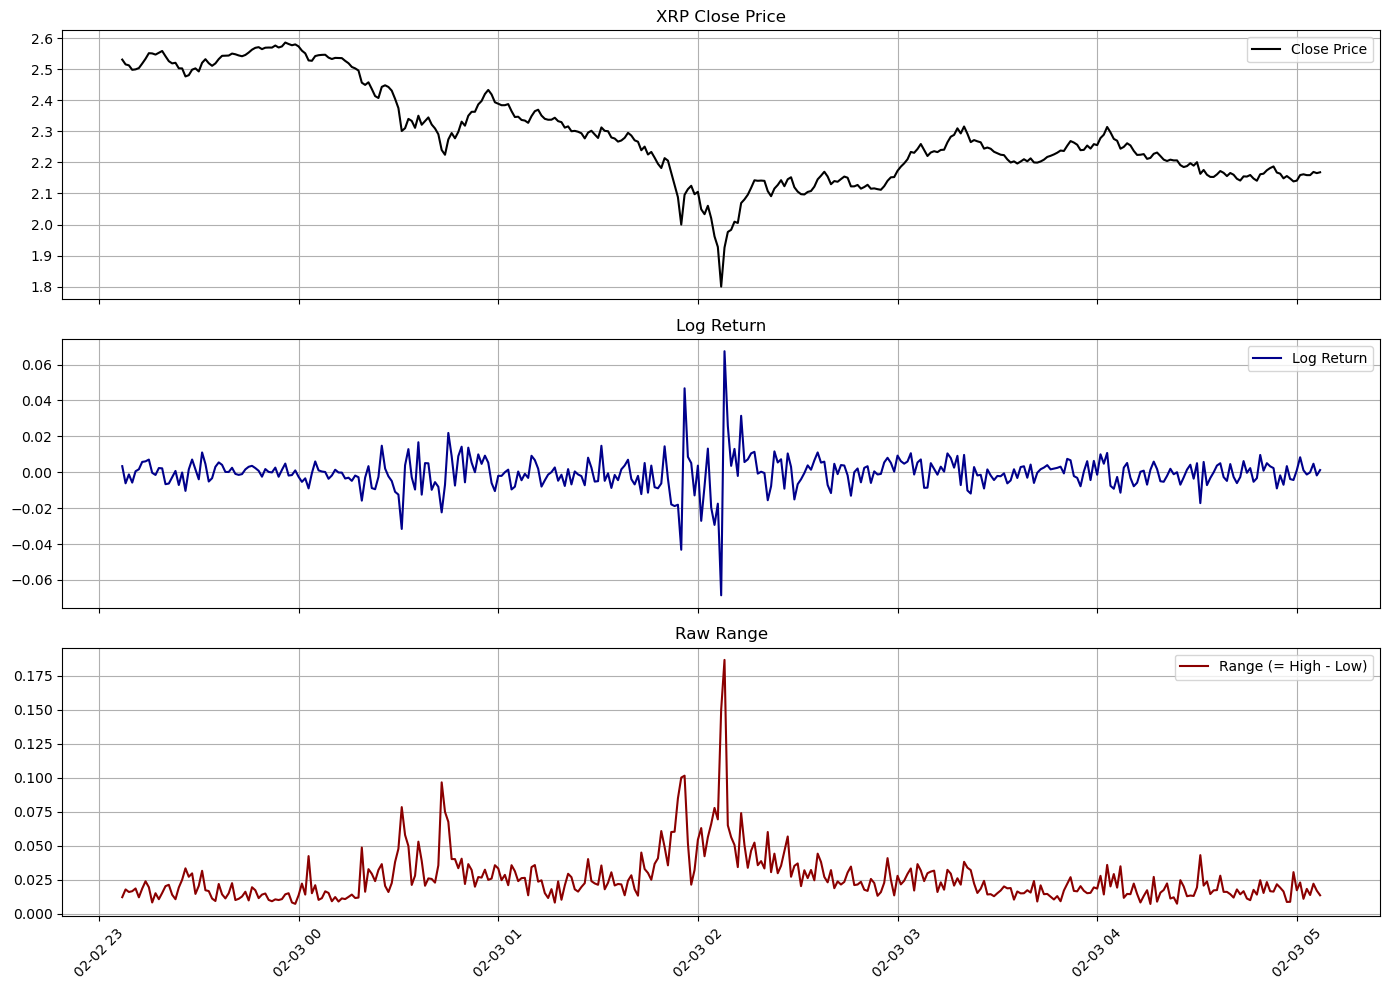

In [3]:
# Create a figure with 3 rows and 1 columns of subplots (side-by-side)
# - fig: the overall figure container
# - axs: an array of individual Axes objects, one for each subplot
# - figsize=(14, 10): sets the overall width and height of the figure in inches
# - sharex=True: the figures will share a common x-axis
fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Close Price
axs[0].plot(window.index, window["Close"], color="black", label="Close Price")
axs[0].set_title("XRP Close Price")
axs[0].legend()
axs[0].grid(True)

# Log Return
axs[1].plot(window.index, window["log_return"], color="darkblue", label="Log Return")
axs[1].set_title("Log Return")
axs[1].legend()
axs[1].grid(True)

# Raw Range
axs[2].plot(window.index, window["raw_range"], color="darkred", label="Range (= High - Low)")
axs[2].set_title("Raw Range")
axs[2].legend()
axs[2].grid(True)

# Beautify x-axis
# Rotating tick labels 45 degrees
# By applying the formatting in a loop, we ensure all three panels remain synchronized and legible.
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

# Automatically adjusts subplot spacing to prevent label and title overlap
# Ensures that axes, tick labels, and titles fit cleanly within the figure bounds
plt.tight_layout()
plt.show()

> ## Comparing Log Return and Raw Range Around a Major Drop
>
> We compare the two measures of price change at this point:
>
> - **Log Return** (blue), which reflects the **directional change** from one close to the next
> - **Raw Range** (red), which reflects **total volatility** within a candle, regardless of direction
>
> A major drop occurs around **02:07**, which is clearly captured by a sharp negative spike in the log return series. This is due to a rapid displacement between consecutive closing prices and log return captures this precisely.
>
> In contrast, the raw range also rises sharply, but not only at the drop. Neighboring candles exhibit elevated range values as well, indicating **continued price instability** within individual candles even after the directional move.
>
> **Key insight:**  
> Log return is highly sensitive to **net directional jumps**, while raw range reveals broader **intraperiod chaos**. The two are complementary: one measures *destination*, the other *path turbulence*.

## Visual Comparison: Log Return and Raw Range During July 10–18, 2025

This 3-panel chart shows XRP price activity during the final 8 days of the dataset, offering a recent look at short-term volatility dynamics.

We visualize:

- **Top Panel: Close Price**  
  Captures the overall trend in XRP prices, showing a period of relatively stable upward movement.

- **Middle Panel: Log Return**  
  Reflects close-to-close directional changes at the 1-minute level. We observe bursts of positive and negative return activity, but no extreme jump like the February event.

- **Bottom Panel: Raw Range (High - Low)**  
  Measures volatility *within* each candle. Range spikes are visible throughout, especially around July 11 and July 17, indicating local price turbulence even when net price movement is modest.

**Interpretation:**  
In contrast to the February 3rd drop, this week shows **broader but less concentrated volatility**. Log return activity is distributed and balanced, while range reveals ongoing micro-level instability. This highlights how raw range can reveal noise and pressure in the market even during structurally upward trends.

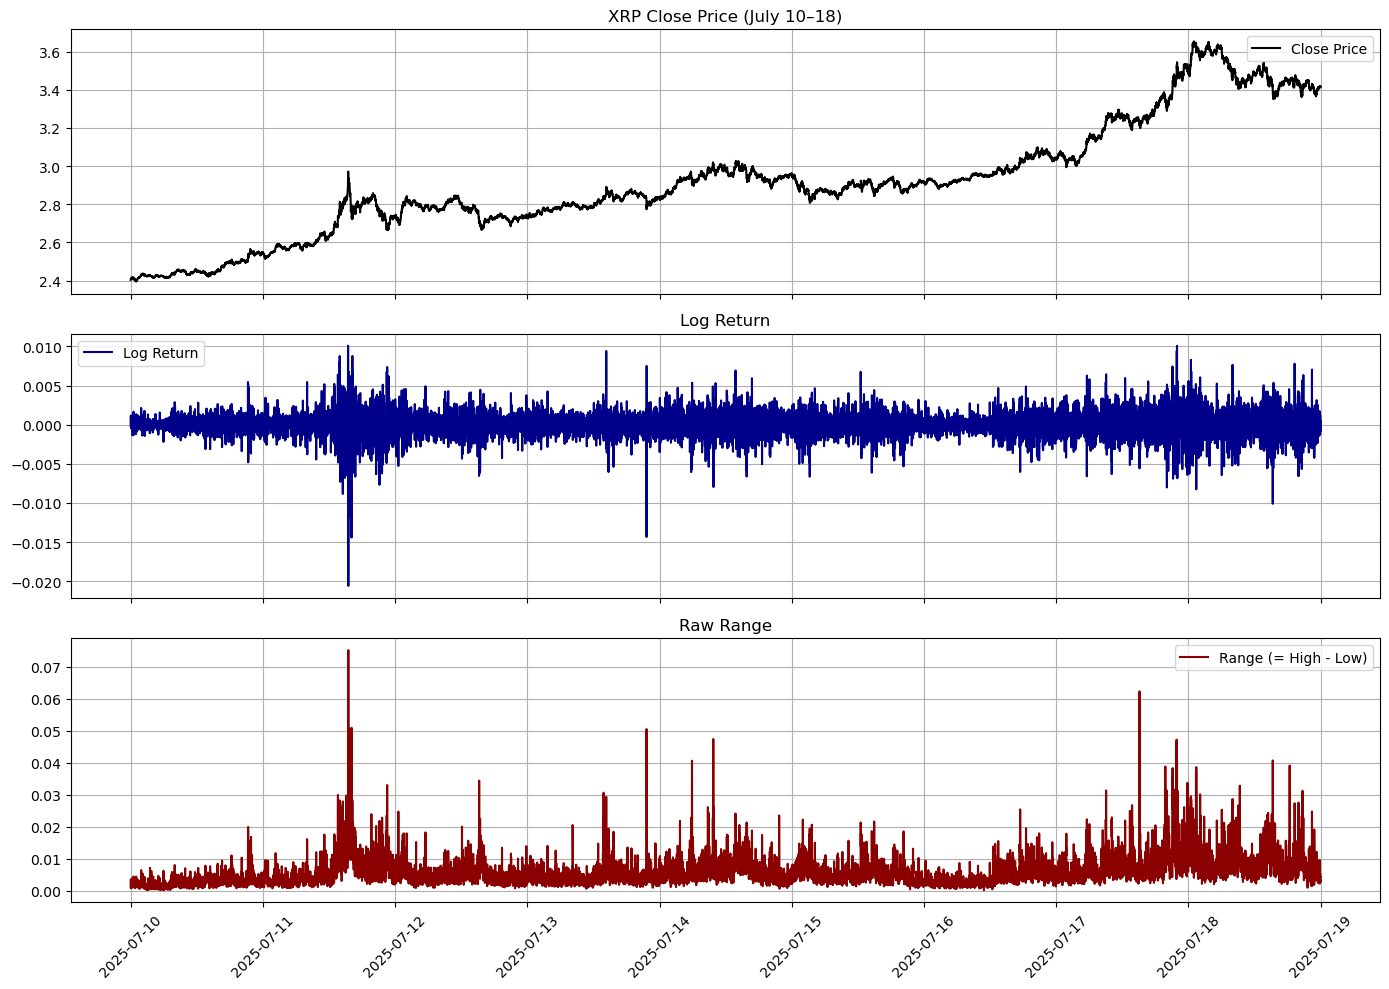

In [4]:
# Extract July 10 to July 18
window_july = df.loc["2025-07-10":"2025-07-18"]

fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Close Price
axs[0].plot(window_july.index, window_july["Close"], color="black", label="Close Price")
axs[0].set_title("XRP Close Price (July 10–18)")
axs[0].legend()
axs[0].grid(True)

# Log Return
axs[1].plot(window_july.index, window_july["log_return"], color="darkblue", label="Log Return")
axs[1].set_title("Log Return")
axs[1].legend()
axs[1].grid(True)

# Raw Range
axs[2].plot(window_july.index, window_july["raw_range"], color="darkred", label="Range (= High - Low)")
axs[2].set_title("Raw Range")
axs[2].legend()
axs[2].grid(True)

for ax in axs:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

> ## Comparing Log Return and Raw Range: July 10–18, 2025
>
> We observe several key moments:
> - Around **July 11**, a sharp downward spike in log return coincides with large values in raw range, suggesting a directional drop with significant turbulence
> - Around **July 17**, raw range rises again, but without as dramatic a response in log return, indicating volatility *within* candles rather than strong directional change between closes
>
> **Takeaway:**  
> Whereas log return emphasizes displacement between closing prices (i.e., the market's "destination"), raw range highlights turbulence *during* the candle (i.e., the market's "path"). The July 10-18 window showcases both aligned spikes (e.g., July 11) and diverging behaviors (e.g., July 17), reinforcing the complementary nature of these two volatility indicators.

## Resampling to Hourly Frequency for Distributional Analysis

To better understand the overall structure of volatility in the dataset, we resample the original 1-minute XRP data to **1-hour frequency**. This transformation smooths out high-frequency noise and prepares the data for **distributional analysis** of log returns and price ranges over longer intervals.

During resampling:
- The **first open**, **maximum high**, **minimum low**, and **last close** within each hour are retained
- We compute:
  - **Hourly Log Return**: log(Close_t / Close_{t-1}) (directional change from hour to hour)
  - **Hourly Raw Range**: High - Low (total price movement within each hour)

This aggregation enables us to construct histograms and analyze how return and volatility are distributed:
- Across the **entire year-to-date**
- During the **largest volatility event (Feb 3)**
- During a **recent active week (July 10-18)**

These hourly-level signals are particularly useful for modeling volatility regimes and comparing volatility under different market conditions.

In [5]:
# Resample to hourly
df_hourly = df.resample("1h").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last"
})

# Compute hourly log return and raw range
df_hourly["log_return"] = np.log(df_hourly["Close"] / df_hourly["Close"].shift(1))
df_hourly["raw_range"] = df_hourly["High"] - df_hourly["Low"]

# Drop rows with NaNs introduced by shift() or resampling gaps
df_hourly = df_hourly.dropna()
df_hourly.tail()

,Open,High,Low,Close,log_return,raw_range
Open time,,,,,,
2025-07-18 19:00:00,3.4395,3.4789,3.4028,3.4340,-0.001629,0.0761
2025-07-18 20:00:00,3.4339,3.4488,3.3576,3.4119,-0.006456,0.0912
2025-07-18 21:00:00,3.4119,3.4517,3.4028,3.4132,0.000381,0.0489
2025-07-18 22:00:00,3.4132,3.4315,3.3779,3.3916,-0.006348,0.0536
2025-07-18 23:00:00,3.3916,3.4214,3.3624,3.4153,0.006964,0.0590


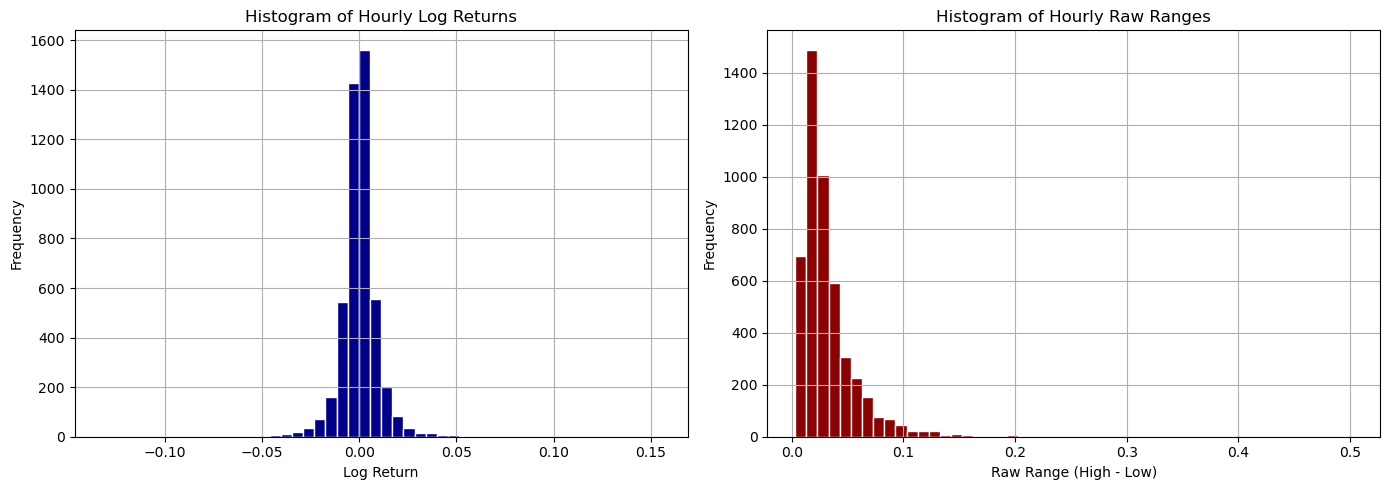

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of log returns
axs[0].hist(df_hourly["log_return"], bins=50, color="darkblue", edgecolor="white")
axs[0].set_title("Histogram of Hourly Log Returns")
axs[0].set_xlabel("Log Return")
axs[0].set_ylabel("Frequency")
axs[0].grid(True)

# Histogram of raw range
axs[1].hist(df_hourly["raw_range"], bins=50, color="darkred", edgecolor="white")
axs[1].set_title("Histogram of Hourly Raw Ranges")
axs[1].set_xlabel("Raw Range (High - Low)")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

plt.tight_layout()
plt.show()

> ## Distribution of Hourly Log Returns and Raw Ranges (Full Dataset)  
>
> These histograms summarize the behavior of XRP's hourly price dynamics from January through July 18, 2025.  
>
> - **Left: Log Return Distribution**  
>   Shows the frequency of directional price changes between hourly closes. The shape is bell-like and centered around zero, consistent with a mean-reverting market. Slight skewness or fat tails may reflect brief periods of directional shock.  
>
> - **Right: Raw Range Distribution**  
>   Displays the spread of hourly intraperiod volatility (High - Low). The distribution is strongly right-skewed, with most ranges clustering near 0.02–0.05, but a few extending beyond 0.10—highlighting rare but significant spikes in turbulence.  
>
> **Interpretation:**  
> These distributions provide a reference baseline for evaluating *local anomalies* (e.g., in February or July windows). They also help in identifying potential **volatility regimes**: persistent shifts in the shape, spread, or skewness of these distributions may signal structural changes in the market’s behavior.

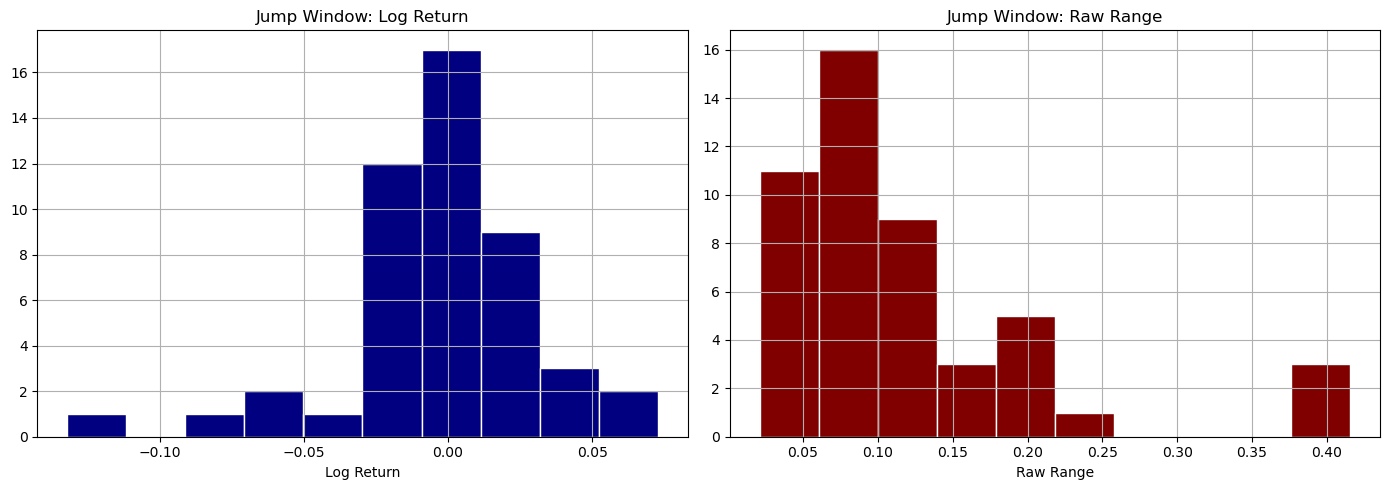

In [7]:
# Slice the Windows from df_hourly
# Largest jump window (±24 hours around Feb 3 jump)
jump_time = pd.Timestamp("2025-02-03 02:07")
jump_slice = df_hourly.loc[jump_time - pd.Timedelta("24h") : jump_time + pd.Timedelta("24h")]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Log return — jump window
axs[0].hist(jump_slice["log_return"], bins=10, color="navy", edgecolor="white")
axs[0].set_title("Jump Window: Log Return")
axs[0].set_xlabel("Log Return")
axs[0].grid(True)

# Raw range — jump window
axs[1].hist(jump_slice["raw_range"], bins=10, color="maroon", edgecolor="white")
axs[1].set_title("Jump Window: Raw Range")
axs[1].set_xlabel("Raw Range")
axs[1].grid(True)

plt.tight_layout()
plt.show()

> ## Distribution of Hourly Log Return and Raw Range Around the February 3 Jump  
>
> To examine how volatility manifests during a major market shock, we isolate a 48-hour window centered on the largest 1-minute log return in the dataset, which occurred on February 3, 2025 at 02:07.  
>
> After resampling to 1-hour intervals, we generate histograms for both:  
>
> - **Log Return (left):**  
>   The distribution is skewed slightly negative, with one or more extreme values representing the directional drop. The remainder of the distribution appears relatively balanced, consistent with recovery or noise following the event.  
>
> - **Raw Range (right):**  
>   This distribution is right-skewed, with most values modest and a small number of large spikes reflecting elevated volatility during and after the jump. These extended tails indicate ongoing instability beyond the initial displacement.  
>
> **Interpretation:**  
> During sudden market moves, log return spikes sharply in one direction, while raw range remains elevated over a broader period—capturing lingering turbulence. These charts reinforce the idea that **log return marks the shock**, while **range maps the aftershocks**.

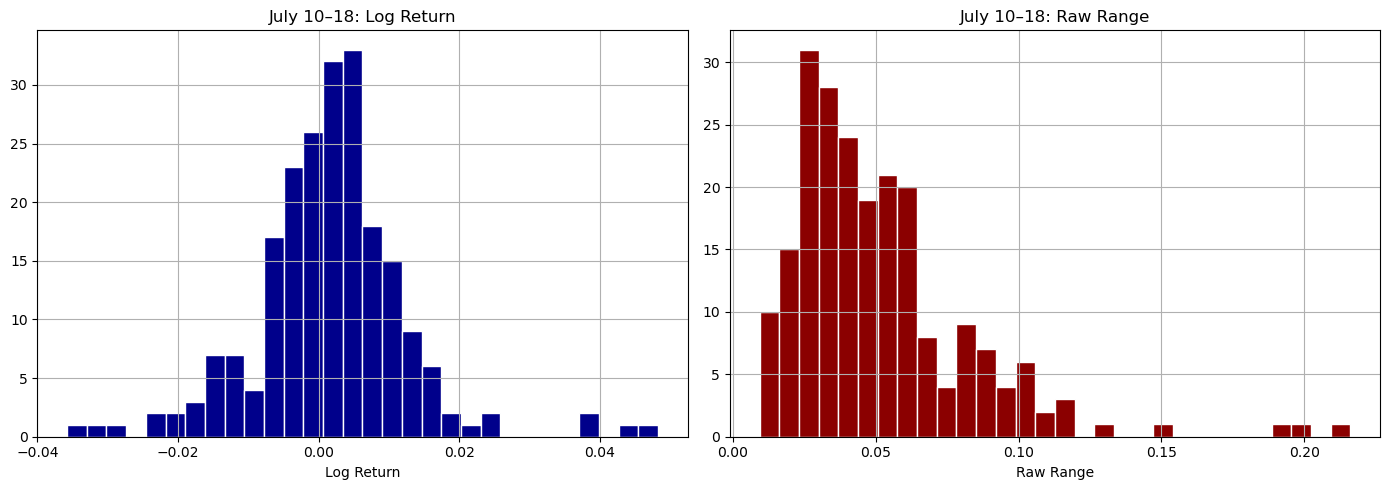

In [8]:
# Slice the Windows from df_hourly
# July 10–18 slice
july_slice = df_hourly.loc["2025-07-10":"2025-07-18"]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(july_slice["log_return"], bins=30, color="darkblue", edgecolor="white")
axs[0].set_title("July 10–18: Log Return")
axs[0].set_xlabel("Log Return")
axs[0].grid(True)

axs[1].hist(july_slice["raw_range"], bins=30, color="darkred", edgecolor="white")
axs[1].set_title("July 10–18: Raw Range")
axs[1].set_xlabel("Raw Range")
axs[1].grid(True)

plt.tight_layout()
plt.show()

> ## Hourly Distribution During the July 10-18 Window  
>
> These histograms show the distribution of hourly log returns and raw price ranges during the July 10–18 period, a dynamic week for XRP.  
>
> - **Log Return (left):**  
>   The distribution is centered near zero and slightly skewed to the right, indicating that upward hourly moves were more common or slightly larger than downward ones. The shape is reasonably Gaussian, consistent with a volatile but trending market.  
>
> - **Raw Range (right):**  
>   The range distribution is heavily right-skewed, as expected. Most hourly candles showed modest intraperiod motion (0.02-0.06), but several outliers extended past 0.10, signaling spikes in volatility that log return alone might miss.  
>
> **Insight:**  
> Compared to the sharp jump window, the July period shows more balanced returns and a broader, but less extreme, range distribution. This reinforces the idea that price was moving *consistently upward*, but not with the same violent displacement observed in early February.

# Summary: Log Return and Raw Range as Complementary Volatility Measures

This notebook explored how two volatility metrics, log return and raw range, capture different aspects of short-term price dynamics in XRP.

- **Log return** quantifies **net directional movement** between candle closes. It is well-suited for identifying sharp jumps, directional shifts, and modeling market impact.
- **Raw range** captures the **intraperiod spread** (High - Low) and is sensitive to chaotic, high-frequency turbulence that may be invisible to return-based analysis.

### Key Findings:
- Around the **February 3 volatility spike**, log return revealed the exact timing and severity of the directional drop, while raw range remained elevated before and after, suggesting ongoing instability.
- During the **July 10-18 period**, log returns were more balanced, but range remained active, indicating subtle volatility not always matched by directional displacement.
- The **full-year distributions** confirmed that log return is centered and symmetric (albeit with mild tails), while raw range exhibits a strongly right-skewed distribution which is consistent with the occasional eruption of extreme candles.

### Final Insight:
Log return and raw range do not duplicate each other, rather they highlight **distinct market regimes**. Log return marks the moments the market *moves*, while range reveals when it *shakes*. Used together, they provide a richer lens for interpreting volatility and anticipating structural changes in price behavior.